In [1]:
%load_ext autoreload
%autoreload 2

In [63]:
from skew_correction.model import MyModelModule, TimmClassifier
import torch
import timm
import os
from torchvision import transforms
import matplotlib.pyplot as plt
from skew_correction.helper import read_raw_image, get_images_in_dir, pil2np, np2pil, tensor2pil, get_skew
from skew_correction.constants import root_dir, angle2label, label2angle

In [5]:
# load model 


model = timm.create_model('resnet18', pretrained=False, num_classes=4, in_chans=1)
ckpt_path = "/home/deepam_minda_farmart_co/fmt/skew_correction/checkpoints/epoch=12-val_loss=0.18-val_acc=0.97.ckpt"
checkpoint = torch.load(ckpt_path)
l = len('model.backbone')
checkpoint["state_dict"] = {k[l+1:]:v for k,v in checkpoint["state_dict"].items()}

In [6]:
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [8]:
imgpaths = get_images_in_dir('../data/rotated/predict/', return_path=True)
img = read_raw_image(imgpaths[2])

In [9]:
tensor_transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.GaussianBlur(1),
    transforms.ColorJitter(0.2),
])

# img_arr = pil2np(img)

tensor = tensor_transform(img)
tensor = tensor.unsqueeze(0)


In [73]:
def hough_transform(img):
    """"takes read_raw_image output as input (pil images). returns rectified pil img grayscale"""
    angle = get_skew(img)
    return img.rotate(angle, expand=True), angle


def remove_padding(image):
    # Get the bounding box of the non-zero (non-padding) region in the image
    bbox = image.getbbox()

    if bbox:
        # Crop the image to the bounding box to remove the padding
        cropped_image = image.crop(bbox)
        return cropped_image
    else:
        # If the entire image is padding, return the original image
        return image

In [85]:
def predict_single_tensor(tensor, debug=True):
    model.eval()
    with torch.no_grad():
        
        outs = (model(tensor))
        # print(outs)
        pred_class = torch.argmax(outs, axis=1).item()

    return pred_class


def predict_in_dir(folder='../data/rotated/predict/', debug=True, max=10, save_to_dir=False, shuffle=False):
    
    imgpaths = get_images_in_dir(folder, return_path=True, shuffle=shuffle)

    for idx, path in enumerate(imgpaths):

        if idx>max:
            break
        
        org_img = read_raw_image(path)
        img, angle = hough_transform(org_img)

        tensor = tensor_transform(img)
        tensor = tensor.unsqueeze(0)
        pred_class = predict_single_tensor(tensor, True)


        if debug==True:
            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
            axes[0].imshow(pil2np(org_img))
            axes[0].set_title("original image")
            axes[1].imshow(pil2np(img))
            axes[1].set_title(f"after hough transform {round(angle, 2)}")
            axes[2].imshow(tensor.squeeze(0).numpy().transpose(1, 2, 0))
            axes[2].set_title(f"label: {pred_class}")
            plt.tight_layout()

            # Display the figure with subplots
            plt.show()

        if save_to_dir:
            output_file = os.path.join(root_dir, "data/fixed_images/") + path.split('/')[-1]
            print(output_file)
            fixed_img = img.rotate(360-label2angle[pred_class], expand=True)
            fixed_img = remove_padding(fixed_img)
            fixed_img.save(output_file)



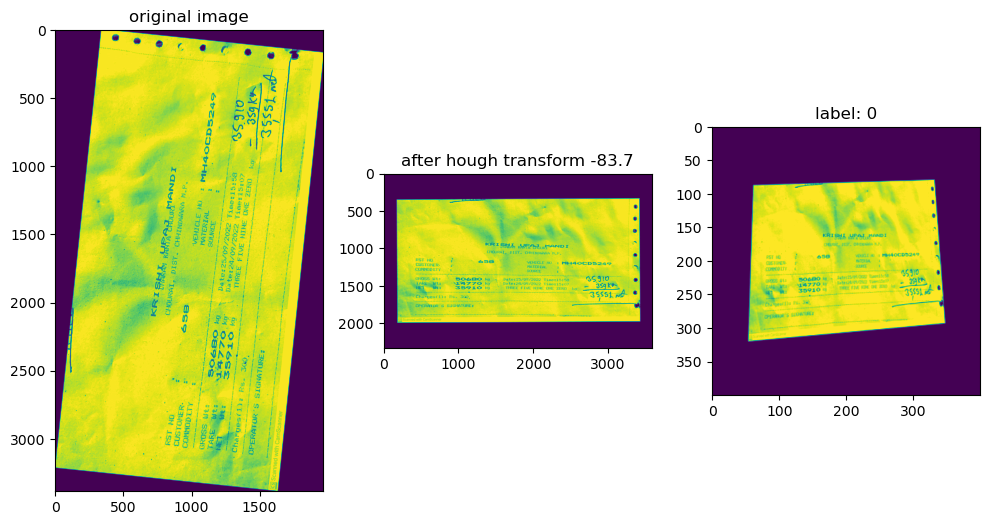

/home/deepam_minda_farmart_co/fmt/skew_correction/data/fixed_images/1664104815645-weight slip_84.jpg


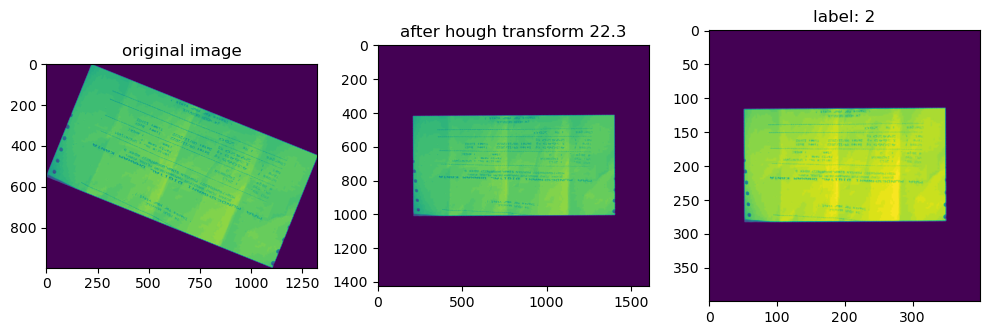

/home/deepam_minda_farmart_co/fmt/skew_correction/data/fixed_images/1667963994238-weight_slip_158.jpg


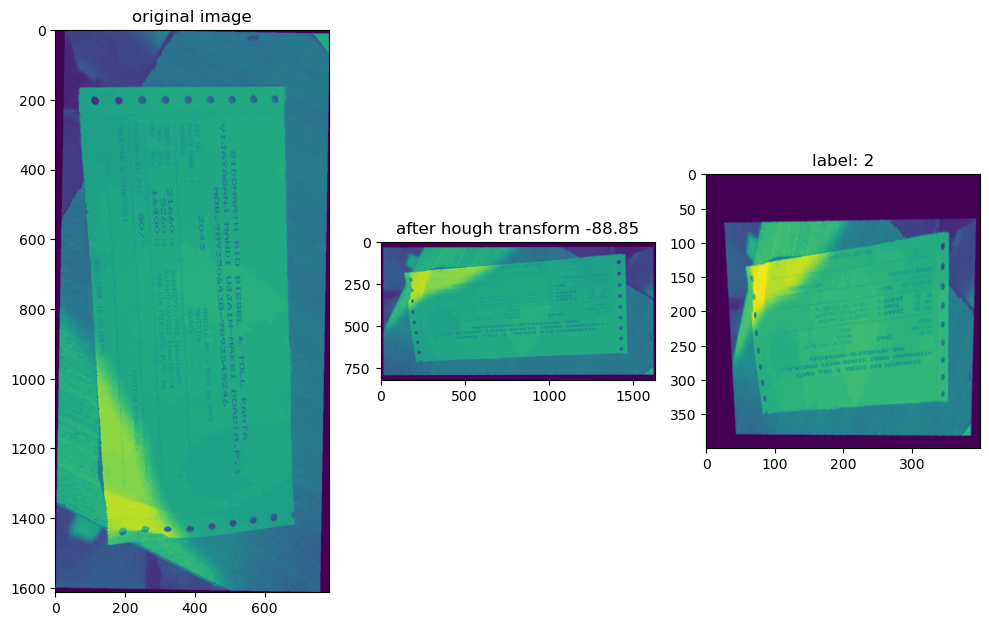

/home/deepam_minda_farmart_co/fmt/skew_correction/data/fixed_images/1670427763306-weight_slip_269.jpg


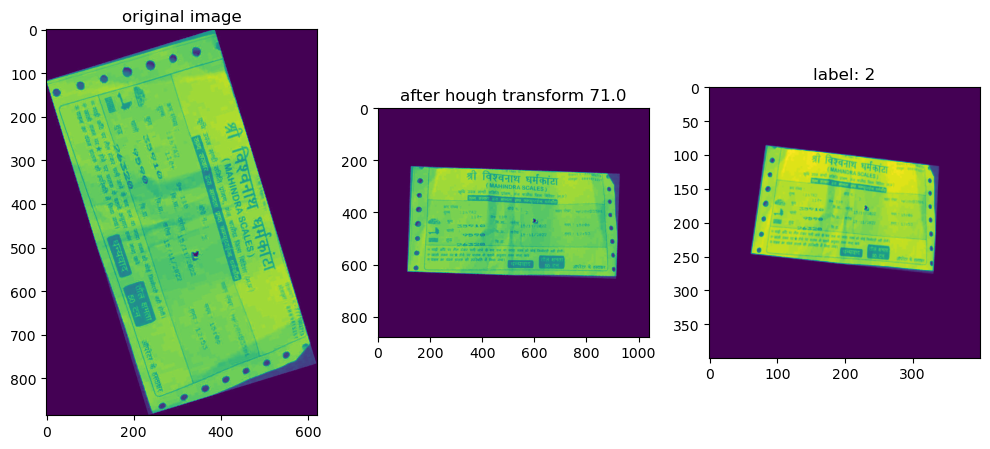

/home/deepam_minda_farmart_co/fmt/skew_correction/data/fixed_images/1668665040771-weight_slip_287.jpg


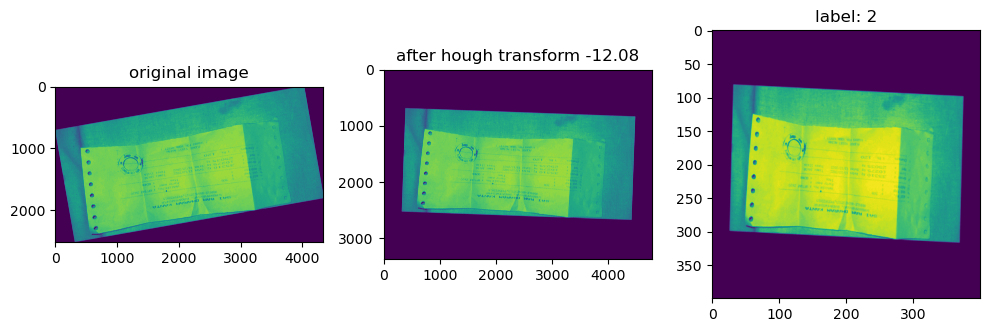

/home/deepam_minda_farmart_co/fmt/skew_correction/data/fixed_images/1670935109675-weight_slip_190.jpg


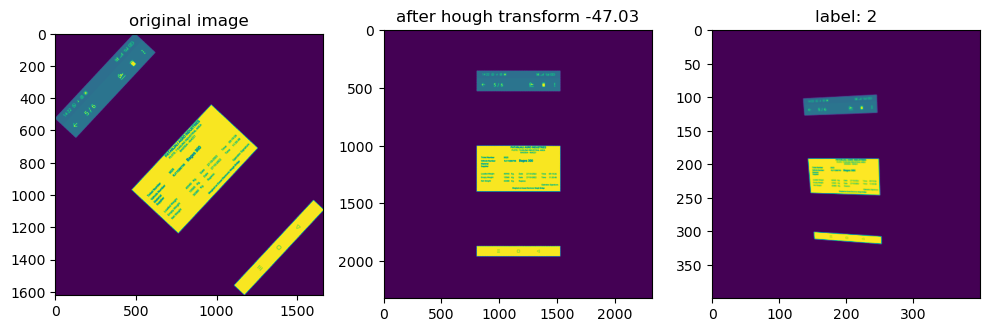

/home/deepam_minda_farmart_co/fmt/skew_correction/data/fixed_images/1666948373308-weight_slip_47.jpg


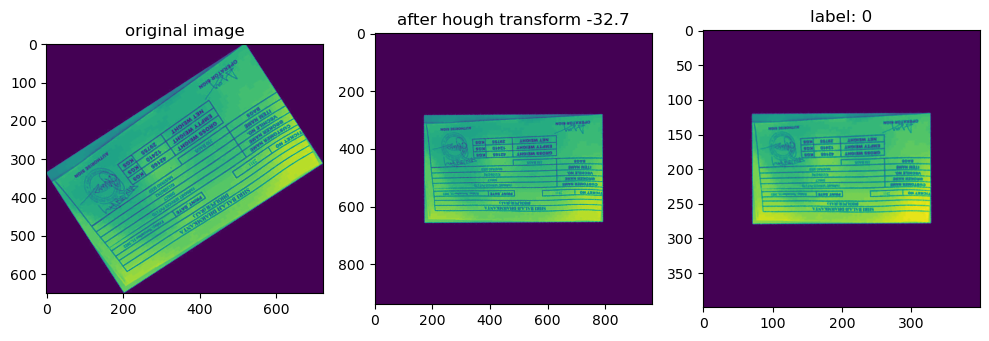

/home/deepam_minda_farmart_co/fmt/skew_correction/data/fixed_images/1668495135356-weight_slip_213.jpg


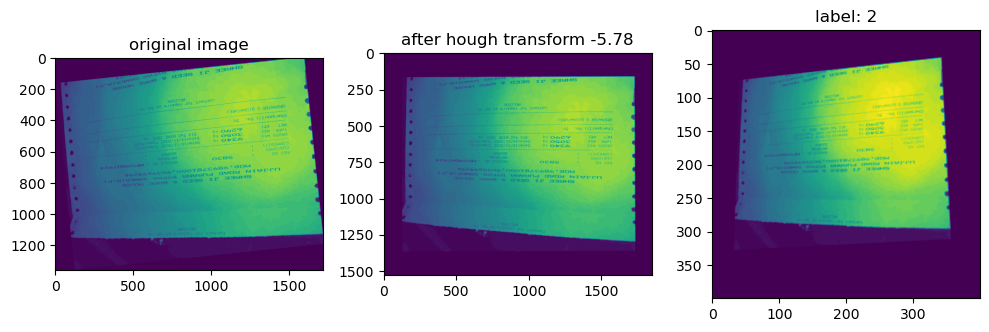

/home/deepam_minda_farmart_co/fmt/skew_correction/data/fixed_images/1668613511961-weight_slip_186.jpg


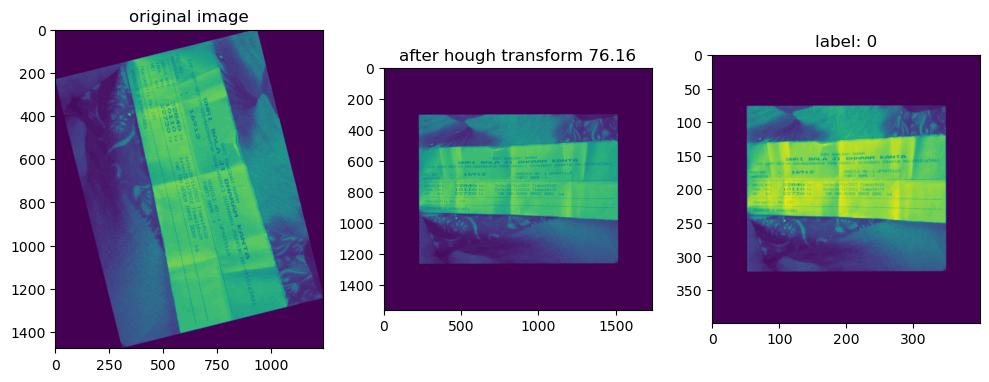

/home/deepam_minda_farmart_co/fmt/skew_correction/data/fixed_images/1669280915590-weight_slip_284.jpg


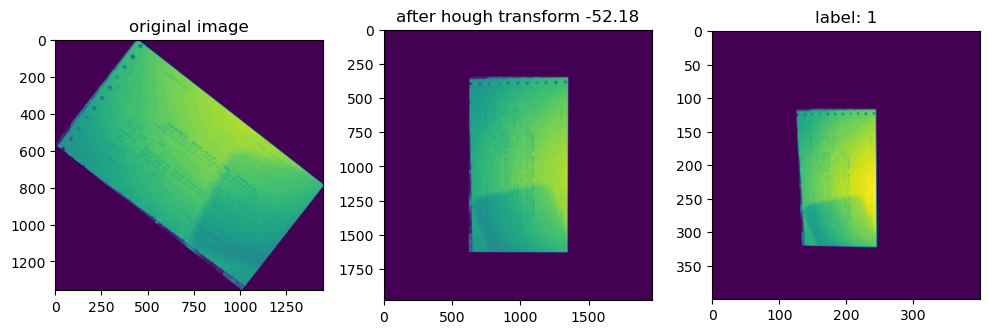

/home/deepam_minda_farmart_co/fmt/skew_correction/data/fixed_images/1667099241673-weight_slip_322.jpg


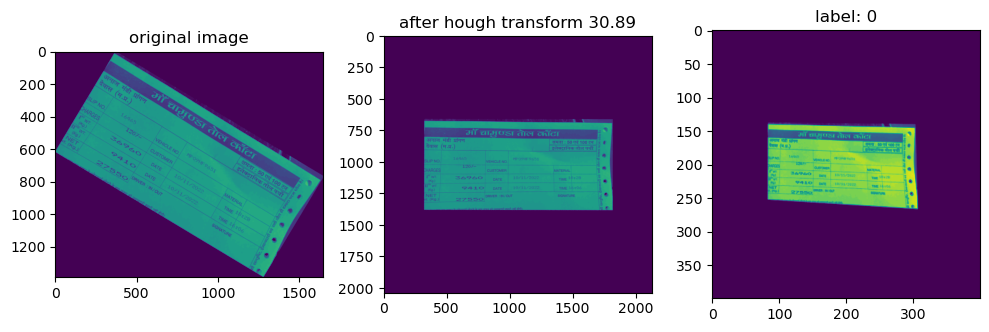

/home/deepam_minda_farmart_co/fmt/skew_correction/data/fixed_images/1668092620435-weight_slip_329.jpg


In [89]:
predict_in_dir(
    folder="/home/deepam_minda_farmart_co/fmt/document-alignment-detection/document_alignment_correction/data/rotated_images/train/",
    max=10,
    save_to_dir=True,
    shuffle=False
)
# predict_single_tensor(tensor)